In [106]:
import cv2
import scipy
import numpy as np
import glob
import matplotlib.pyplot as plt
import math
from scipy.optimize import least_squares

np.set_printoptions(suppress=True)

ImageType = "*.jpg"
FolderPath = "./Calibration_Imgs/"

ImageType = "*.jpg"
FolderPath = "./Calibration_Imgs/"
row = 6
col = 9
edge = 21.5

ImagePaths = glob.glob(FolderPath + ImageType)
ImagePaths.sort()
patternSize = (col, row)

worldCorners = np.mgrid[0:row, 0:col].swapaxes(0, 2).swapaxes(0, 1).reshape(-1, 2) * edge
worldCorners = np.hstack((worldCorners, np.ones((row * col, 1))))
print(worldCorners)
# print(worldCorners.T.reshape(-1, 2))
print(worldCorners.shape)

[[  0.    0.    1. ]
 [  0.   21.5   1. ]
 [  0.   43.    1. ]
 [  0.   64.5   1. ]
 [  0.   86.    1. ]
 [  0.  107.5   1. ]
 [  0.  129.    1. ]
 [  0.  150.5   1. ]
 [  0.  172.    1. ]
 [ 21.5   0.    1. ]
 [ 21.5  21.5   1. ]
 [ 21.5  43.    1. ]
 [ 21.5  64.5   1. ]
 [ 21.5  86.    1. ]
 [ 21.5 107.5   1. ]
 [ 21.5 129.    1. ]
 [ 21.5 150.5   1. ]
 [ 21.5 172.    1. ]
 [ 43.    0.    1. ]
 [ 43.   21.5   1. ]
 [ 43.   43.    1. ]
 [ 43.   64.5   1. ]
 [ 43.   86.    1. ]
 [ 43.  107.5   1. ]
 [ 43.  129.    1. ]
 [ 43.  150.5   1. ]
 [ 43.  172.    1. ]
 [ 64.5   0.    1. ]
 [ 64.5  21.5   1. ]
 [ 64.5  43.    1. ]
 [ 64.5  64.5   1. ]
 [ 64.5  86.    1. ]
 [ 64.5 107.5   1. ]
 [ 64.5 129.    1. ]
 [ 64.5 150.5   1. ]
 [ 64.5 172.    1. ]
 [ 86.    0.    1. ]
 [ 86.   21.5   1. ]
 [ 86.   43.    1. ]
 [ 86.   64.5   1. ]
 [ 86.   86.    1. ]
 [ 86.  107.5   1. ]
 [ 86.  129.    1. ]
 [ 86.  150.5   1. ]
 [ 86.  172.    1. ]
 [107.5   0.    1. ]
 [107.5  21.5   1. ]
 [107.5  43. 

[[[ 435.05212 1399.1493 ]]

 [[ 442.3084  1283.7079 ]]

 [[ 449.4941  1170.5732 ]]

 [[ 456.6978  1060.352  ]]

 [[ 463.61014  951.7264 ]]

 [[ 470.9368   845.1977 ]]

 [[ 477.80817  741.38464]]

 [[ 485.34464  639.8741 ]]

 [[ 491.74182  540.4603 ]]

 [[ 553.5663  1402.7157 ]]

 [[ 560.0045  1287.5702 ]]

 [[ 566.03735 1174.5759 ]]

 [[ 571.70667 1063.4319 ]]

 [[ 578.1571   955.1032 ]]

 [[ 583.3935   847.9079 ]]

 [[ 589.6987   743.4091 ]]

 [[ 595.02167  641.7797 ]]

 [[ 601.1863   542.3715 ]]

 [[ 671.9406  1405.8596 ]]

 [[ 676.8103  1290.6704 ]]

 [[ 681.74695 1177.5494 ]]

 [[ 686.896   1066.2689 ]]

 [[ 691.35657  957.27454]]

 [[ 696.53845  850.2712 ]]

 [[ 700.5111   745.3892 ]]

 [[ 705.6471   643.36884]]

 [[ 709.681    544.13055]]

 [[ 790.2703  1408.7975 ]]

 [[ 794.0998  1293.5355 ]]

 [[ 798.3113  1180.4346 ]]

 [[ 802.09436 1068.7302 ]]

 [[ 806.015    959.2229 ]]

 [[ 809.3048   851.5523 ]]

 [[ 813.4426   746.72314]]

 [[ 816.3459   645.13983]]

 [[ 820.1075   545.6

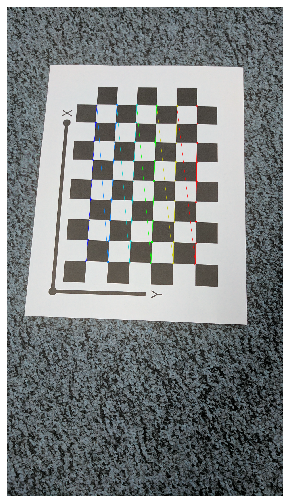

In [113]:
imagePath = ImagePaths[0]
img = cv2.imread(imagePath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plt.axis('off')
# plt.imshow(gray, cmap='gray')

patternSize = (9, 6)

ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
img = cv2.drawChessboardCorners(img, patternSize, corners,ret)

plt.figure(figsize = (16, 9))
plt.axis('off')
plt.imshow(img)

print(corners)

In [107]:
def getImagesCorners(imagePaths, patternSize):
    imgCorners = []
    for imagePath in ImagePaths:
        img = cv2.imread(imagePath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
        if ret:
            imgCorners.append(corners)

    return np.array(imgCorners)

imgPoints = getImagesCorners(ImagePaths, patternSize)

In [108]:
def estimateHomography(imgCorners, worldCorners):
    length = imgCorners.shape[0]
    L = np.zeros((2 * length, 9))
    for i in range(length):
        Lsub = np.zeros((2, 9))
        MT = worldCorners[i, :].T
        Lsub[0, 0:3] = MT
        Lsub[1, 3:6] = MT
        Lsub[0, 6:9] = -imgCorners[i, 0] * MT
        Lsub[1, 6:9] = -imgCorners[i, 1] * MT
        L[2*i: 2*i+2, :] = Lsub

    _, _, VT = np.linalg.svd(L)
    predH = VT[-1, :].reshape((3, 3))
    predH = predH / predH[2, 2]
    return predH

predHs = []
for imgCorners in imgPoints:
    predH = estimateHomography(imgCorners.squeeze(), worldCorners)
    print(predH)
    predHs.append(predH)

[[   5.45923108    0.58179656  434.17910892]
 [   0.02113049   -4.71963114 1399.30227786]
 [  -0.00009601    0.00050473    1.        ]]
[[   6.13202102    0.95884464  361.93083726]
 [   0.21987246   -4.41328418 1477.13293396]
 [   0.00000516    0.00097849    1.        ]]
[[   6.58137748    1.33499883  358.98379152]
 [   0.56616474   -3.8983339  1348.94540366]
 [   0.00012422    0.00139741    1.        ]]
[[   7.16480136    1.33762686  350.69027151]
 [   0.55817066   -3.51735425 1337.91267348]
 [   0.00023727    0.00177412    1.        ]]
[[   4.84798814   -0.02524541  456.56613378]
 [  -0.03713083   -4.84034643 1683.11636747]
 [  -0.00000322   -0.00000518    1.        ]]
[[   6.55873506    0.0142691   384.01000141]
 [   0.02328093   -6.3270449  1684.35240216]
 [   0.00006287    0.00011306    1.        ]]
[[   3.28599107    0.19474802  562.00191132]
 [   0.03831889   -3.09987728 1668.21166099]
 [  -0.00003386    0.00014053    1.        ]]
[[   3.93006317   -0.46003336  584.42926594]
 [ 

In [110]:
def createV(H, i, j):
    return np.array([H[0,i]*H[0,j],
                    H[0,i]*H[1,j] + H[1,i]*H[0,j],
                    H[1,i]*H[1,j],
                    H[2,i]*H[0,j] + H[0,i]*H[2,j],
                    H[2,i]*H[1,j] + H[1,i]*H[2,j],
                    H[2,i]*H[2,j]])

# solve for b
def estimateB(predHs):
    predHs = np.array(predHs)
    length = predHs.shape[0]

    V = np.zeros((2*length, 6))
    for i in range(length):
        V[2 * i] = createV(predHs[i], 0, 1)
        V[2 * i + 1] = createV(predHs[i], 0, 0) - createV(predHs[i], 1, 1)

    _, _, VT = np.linalg.svd(V)
    predb = VT[-1, :]

    return predb

predb = estimateB(predHs)
print(predb)

[ 0.00000015  0.          0.00000015 -0.0001147  -0.00020638  0.99999997]


In [111]:
def estimateIntrinsic(predHs):
    b = estimateB(predHs)
    v0 = (b[1]*b[3] - b[0]*b[4]) / (b[0]*b[2] - b[1]**2)
    scale = b[5] - (b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4]))/b[0]
    fx = math.sqrt(scale / b[0])
    fy = math.sqrt(scale*b[0] / (b[0]*b[2] - b[1]**2))
    skew = -b[1] * fx**2 * fy / scale
    u0 = skew * v0 / fy - b[3] * fx**2 /scale

    K = np.array([[fx, skew, u0],
                  [0, fy, v0],
                  [0, 0, 1]])

    return K

predK = estimateIntrinsic(predHs)
print(predK)

[[2053.04115298   -0.4682871   762.79853868]
 [   0.         2037.10196588 1351.64446416]
 [   0.            0.            1.        ]]


In [114]:
def estimateExtrinsic(K, predHs):
    predHs = np.array(predHs)
    length = predHs.shape[0]

    predRs = []
    predTs = []
    Kinv = np.linalg.inv(K)
    for i in range(length):
        H = predHs[i]
        scale = 1 / np.linalg.norm(np.matmul(Kinv, H[:, 0]))
        R = np.zeros((3, 3))
        R[:, 0] = scale * np.matmul(Kinv, H[:, 0])
        R[:, 1] = scale * np.matmul(Kinv, H[:, 1])
        R[:, 2] = np.cross(R[:, 0], R[:, 1])
        t = scale * np.matmul(Kinv, H[:, 2])

        predRs.append(R)
        predTs.append(t)

    return np.array(predRs), np.array(predTs)

predRs, predTs = estimateExtrinsic(predK, predHs)
print(predRs[0], predTs[0])
print(predRs[1], predTs[1])
print(predRs[2], predTs[2])


[[ 0.99898909  0.03530934 -0.02984885]
 [ 0.02746041 -0.98302964 -0.1881776 ]
 [-0.03559096  0.18711006 -0.9830055 ]] [-59.3359779    8.67278035 370.71230363]
[[ 0.99938612  0.03443186  0.01309238]
 [ 0.03499137 -0.94273248 -0.32735206]
 [ 0.00172771  0.32761266 -0.94335857]] [-65.36945887  20.62499198 334.81332408]
[[ 0.99732353  0.04116268  0.06238132]
 [ 0.06171186 -0.89672574 -0.43830065]
 [ 0.03920989  0.44109521 -0.89686591]] [-62.08605649  -0.4182238  315.6522491 ]


In [84]:
distortion = np.array([0, 0]).T

In [121]:
def initAllParam(ImagePaths, row, col, edge):
    ImagePaths = glob.glob(FolderPath + ImageType)
    ImagePaths.sort()
    patternSize = (col, row)

    worldCorners = np.mgrid[0:row, 0:col].swapaxes(0, 2).swapaxes(0, 1).reshape(-1, 2) * edge
    worldCorners = np.hstack((worldCorners, np.ones((row * col, 1))))

    imgPoints = getImagesCorners(ImagePaths, patternSize)

    predHs = []
    for imgCorners in imgPoints:
        predH = estimateHomography(imgCorners.squeeze(), worldCorners)
        # print(predH)
        predHs.append(predH)

    predK = estimateIntrinsic(predHs)
    predRs, predTs = estimateExtrinsic(predK, predHs)

    distortion = np.array([0, 0]).T

    return predK, predRs, predTs, distortion, imgPoints, worldCorners

initK, initRs, initTs, initDistortion, imgPoints, worldCorners = initAllParam(ImagePaths, row, col, edge)

In [ ]:
def flatten2x0(initK, initDistortion):
    x0 = np.zeros(6)
    x0[0] = initK[0, 0] # fx
    x0[1] = initK[1, 1]
    x0[2] = initK[0, 2]
    x0[3] = initK[1, 2]
    x0[4] = initDistortion[0]
    x0[5] = initDistortion[1]
    return x0

def recoverx0(x0):
    fx, fy, u0, v0 = x0[0:4]
    k1, k2 = x0[4:6]
    K = np.array([[fx, 0, u0],
                  [0, fy, v0],
                  [0, 0, 1]])
    return K, k1, k2

def calibration(x0, initRs, initTs)